In [50]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline 


In [51]:
class PE(nn.Module):
    
    def __init__(self, d_model, max_len=5000):
        
        super(PE, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
    
    
class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_length, output_length, 
                 d_model = 256, nhead = 8, num_layers = 2, dropout=0.5):
        super(TransformerTimeSeriesModel, self).__init__()
        self.output_length = output_length
        self.output_dim = output_dim
        self.src_mask = None
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_coding = PE(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = nhead, 
                                                        dim_feedforward=4 * d_model, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers = num_layers)
        self.fc1 = nn.Linear(seq_length * d_model, output_length * d_model)
        self.fc2 = nn.Linear(output_length * d_model, output_length * output_dim)
        self.init_weights()
        
    def forward(self, src):
        
        if self.src_mask is None:
            device = src.device
            mask = self.mask(len(src)).to(device)
            self.src_mask = mask
        
        src = self.embedding(src)
        src = self.pos_coding(src)
        en_output = self.transformer_encoder(src, self.src_mask)
        en_output = en_output.view(en_output.size(1), -1)
        output = self.fc1(en_output)
        output = self.fc2(output) 
        
        return output.view(-1, self.output_length, self.output_dim)
    
    def init_weights(self):
        initrange = 0.1
        for module in self.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.uniform_(-initrange, initrange)
                if module.bias is not None:
                    module.bias.data.zero_()
    
    def mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [52]:
class get_dataset(Dataset):
    
    def __init__(self, data_path, seq_length, label_length, features):
        self.data_path = data_path
        self.features = features
        self.seq_length = seq_length
        self.label_length = label_length
        self.data, self.data_mean, self.data_std = self.get_data()
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, index):
        en_input = self.data[index, :self.seq_length, :]
        label = self.data[index, -self.label_length:, -1].unsqueeze(1)
        return en_input, label
               
    def get_data(self):
        data = pd.read_csv(self.data_path)
        data.index = pd.to_datetime(data['dteday'])
        data = data.drop('dteday', axis=1)
        data_mean = data.mean()
        data_std = data.std()
        for col in data.columns:
            if data_std[col] == 0:
                print(f"Warning: Column '{col}' has zero variance and will not be normalized.")
            else:
                data[col] = (data[col] - data_mean[col]) / data_std[col]
        num_sample = len(data) - self.seq_length - self.label_length + 1
        print('len(data):', len(data), 'num_sample:', num_sample)
        print('len(self.features):',len(self.features))
        seq_data = torch.zeros(num_sample, self.seq_length + self.label_length, len(self.features))
 
        for i in range(num_sample):
            col_data = data.loc[:, self.features]

            seq_data[i] = torch.tensor(col_data.iloc[i:i + self.seq_length + self.label_length].values)
 
        return seq_data, data_mean, data_std


In [53]:
def train(model, dataset, epochs, optim, batch_size, criterion,shuffle=True):
    print('training on :', device)
    data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=shuffle)
    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for x, label in data_loader:
            x, label = x.permute(1,0,2).to(device), label.to(device)
            pred = model(x) 
            loss = criterion(pred, label)
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss += loss.item()
        train_loss /= len(data_loader)
        print('epoch: %d, lr: %.8f, train loss : %.8f' % (epoch + 1, scheduler.get_last_lr()[0],train_loss))
        scheduler.step() 
    pred_array, true_array = test(model, dataset_test, batch_size,criterion, shuffle=False)

    return pred_array, true_array

In [54]:
def test(model, dataset, batch_size, criterion, shuffle = False):
    
    model.eval()
    val_loss = 0.
    data_loader = DataLoader(dataset, batch_size, shuffle = shuffle)
    pred_list = []
    true_list = []
    
    for x, label in data_loader:
        x, label = x.permute(1,0,2).to(device), label.to(device)
        pred = model(x)
        loss = criterion(pred, label)
        val_loss += loss.item()
        pred = pred.squeeze(2).detach().cpu().numpy()
        true = label.squeeze(2).detach().cpu().numpy()
       
        pred = pred * dataset.data_std['cnt'] + dataset.data_mean['cnt']
        true = true * dataset.data_std['cnt'] + dataset.data_mean['cnt']
        x_true = x.permute(1,0,2)[:, :, -1].detach().cpu().numpy() 
        x_true = x_true * dataset.data_std['cnt'] + dataset.data_mean['cnt']
        combined = np.concatenate((x_true, true), axis=1)
        pred_list.append(pred)
        true_list.append(combined)
    
    pred_array = np.vstack(pred_list)
    true_array = np.vstack(true_list)  
    print(' val loss : %.8f' % (val_loss/len(data_loader)))
    return pred_array, true_array


In [55]:
def draw_one_sample(pred_array, true_array, i=0):
    pred = pred_array[i]
    true = true_array[i]

    historical_true = true[:seq_length]
    target_true = true[seq_length:]

    plt.figure(figsize=(8, 4))
    plt.plot(historical_true, label='Historical Data', color='blue', marker='o', markersize=3)
    plt.plot(range(seq_length, seq_length+output_length), target_true, label='Target True Values', color='green', marker='o', markersize=3)
    plt.plot(range(seq_length, seq_length+output_length), pred, label='Predicted Values', color='red', linestyle='--', marker='x', markersize=3)
    plt.legend()
    plt.title(f'Prediction vs True Values for Sample {i+1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.grid()
    plt.show()


In [56]:
def error(pred_array, true_array,i):
    true_values = true_array[i, -output_length:]
    mae = np.mean(np.abs(pred_array[i,:] - true_values))
    mse = np.mean((pred_array[i,:] - true_values)**2)
    return mae,mse


In [57]:
seed = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
 
seq_length = 96
output_length = 96
features = ['hr', 'holiday', 'weekday', 'workingday', 'weathersit', 
            'temp', 'atemp', 'hum', 'windspeed','cnt'] # 'cnt'为标签列，其历史数据可以帮助预测其未来值，故也可以当作特征
input_size = len(features)
output_size = 1
data_path_train = 'train_data.csv'
data_path_test = 'test_data.csv'
dataset_train = get_dataset(data_path_train, seq_length, output_length, features)
dataset_test = get_dataset(data_path_test, seq_length, output_length, features)



len(data): 15216 num_sample: 15025
len(self.features): 10
len(data): 2160 num_sample: 1969
len(self.features): 10


In [58]:
epochs = 60
batch_size = 32
d_model = 20
nhead = 4
num_layers = 2
dropout = 0.2
pred_array_list = []
for i in range(5):
    lr = 0.001
    model = TransformerTimeSeriesModel(input_size, output_size, seq_length, output_length, d_model, nhead,
                                   num_layers, dropout = dropout).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 1.0, gamma=0.98)
    criterion = nn.MSELoss()
    pred_array, true_array = train(model, dataset_train, epochs, optim, batch_size, criterion, shuffle = True)
    print(pred_array.shape)
    print(true_array.shape)
    pred_array_list.append(pred_array)

numpy_array = np.array(pred_array_list)
np.save('pred_array_list_transformer.npy', numpy_array)
numpy_array = np.array(true_array)
np.save('true_array_transformer.npy', numpy_array)


training on : cuda
epoch: 1, lr: 0.00100000, train loss : 2.76087651
epoch: 2, lr: 0.00098000, train loss : 1.37696257
epoch: 3, lr: 0.00096040, train loss : 1.21965146
epoch: 4, lr: 0.00094119, train loss : 1.13341942
epoch: 5, lr: 0.00092237, train loss : 1.07928050
 val loss : 1.02914800
(1969, 96)
(1969, 192)


5轮训练平均值:
测试集上第11个样本的MAE: 178.1386
测试集上第11个样本的MSE: 49053.402


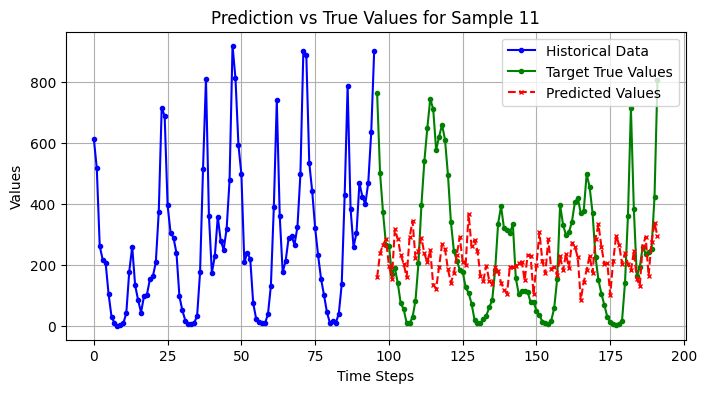

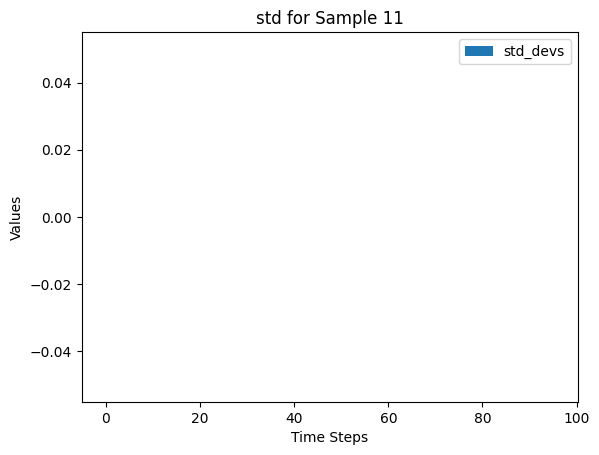

测试集上第211个样本的MAE: 196.70866
测试集上第211个样本的MSE: 62981.426


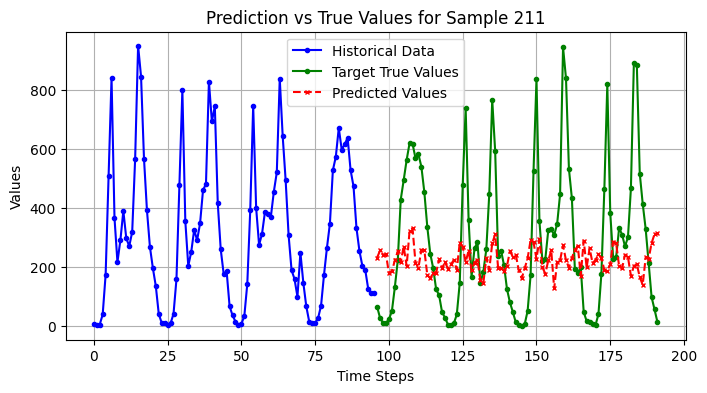

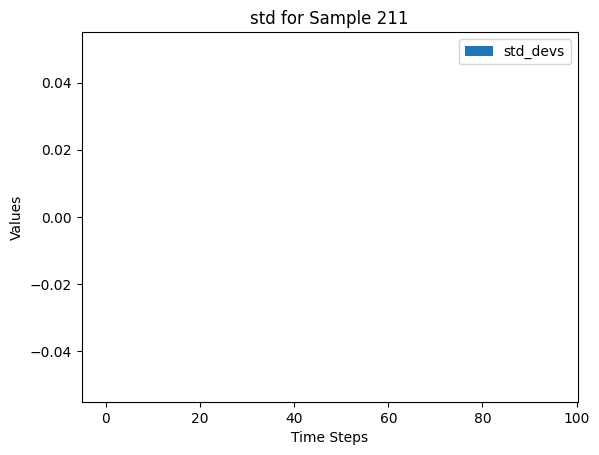

测试集上第411个样本的MAE: 208.07312
测试集上第411个样本的MSE: 75996.52


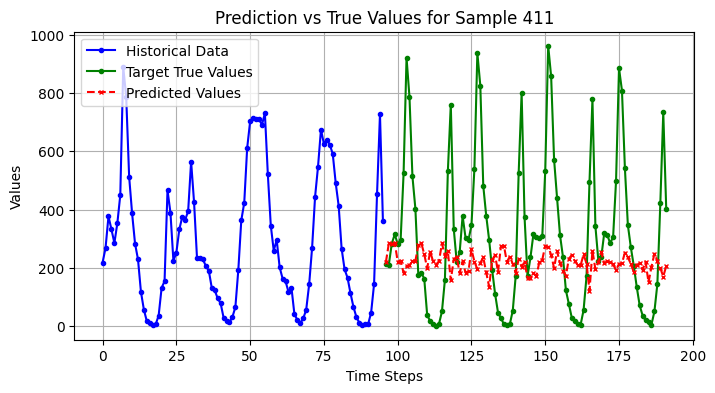

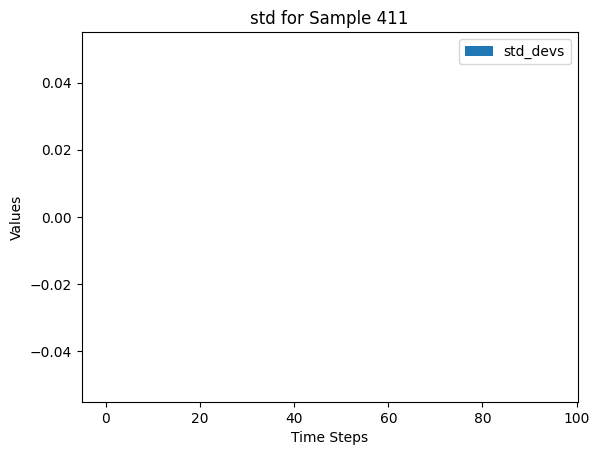

测试集上第611个样本的MAE: 151.16785
测试集上第611个样本的MSE: 34932.176


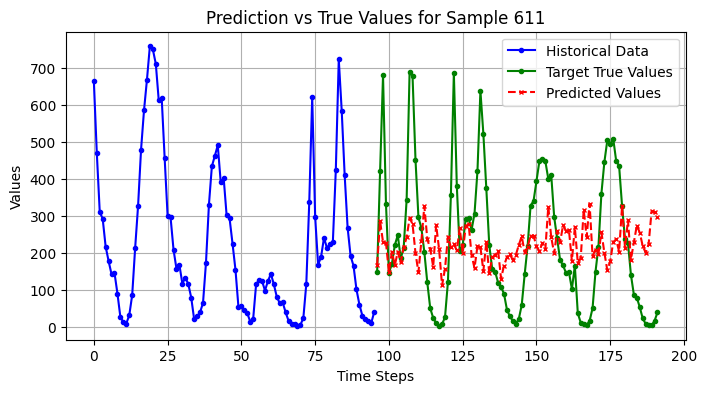

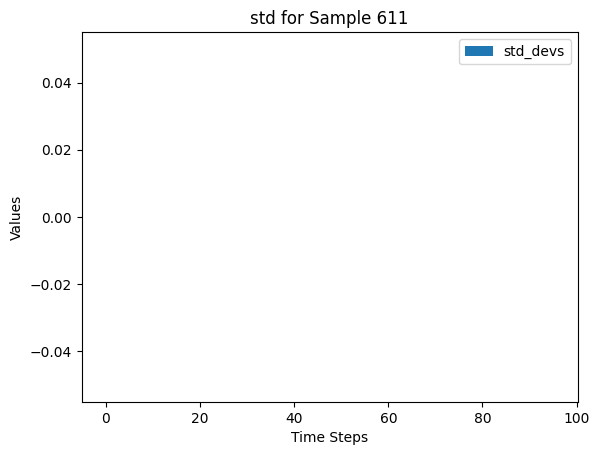

测试集上第811个样本的MAE: 189.27971
测试集上第811个样本的MSE: 51028.906


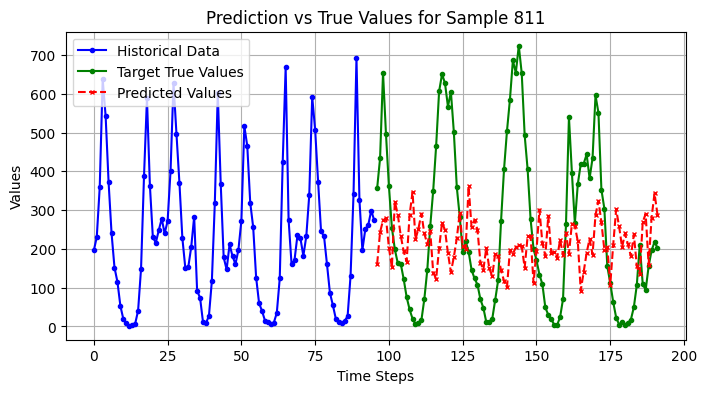

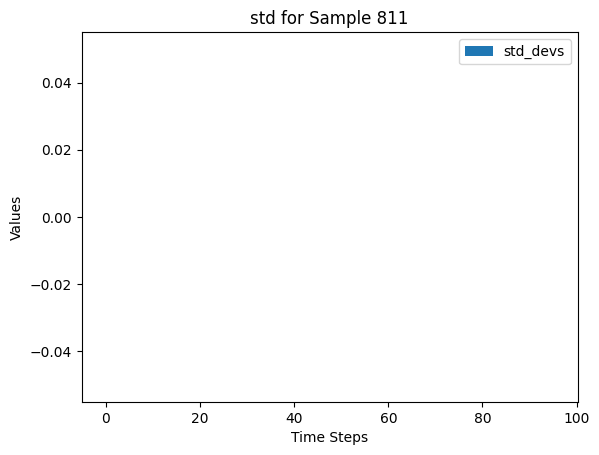

测试集上第1011个样本的MAE: 156.37465
测试集上第1011个样本的MSE: 34396.664


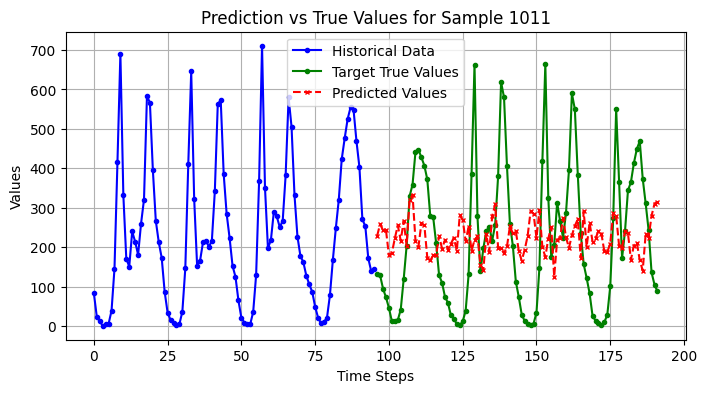

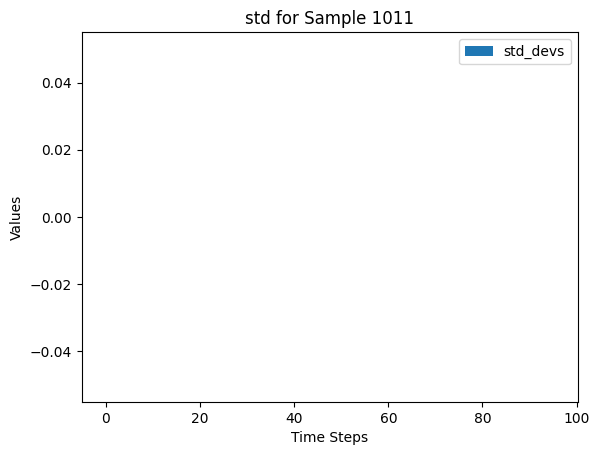

测试集上第1211个样本的MAE: 144.38985
测试集上第1211个样本的MSE: 32429.299


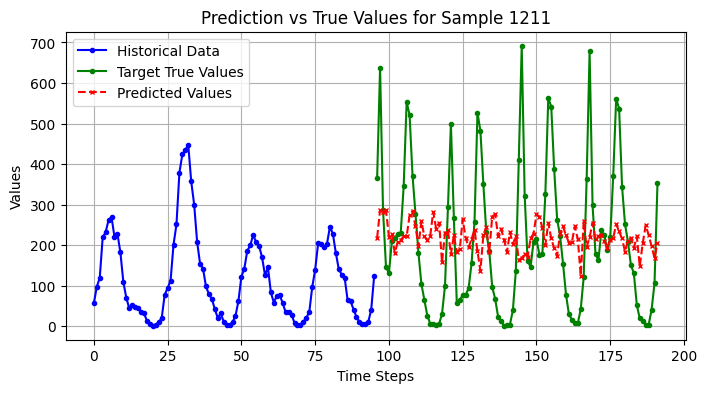

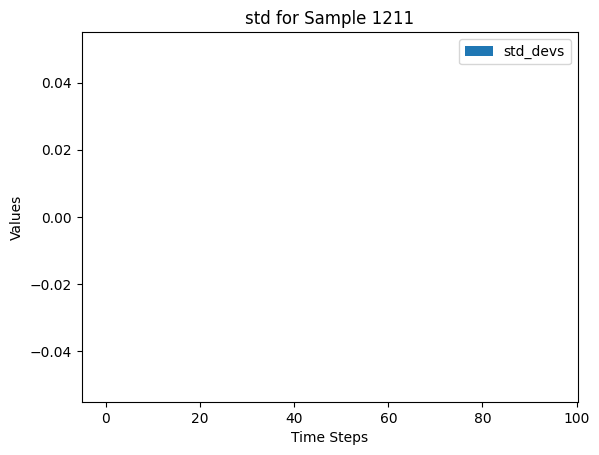

测试集上第1411个样本的MAE: 158.33977
测试集上第1411个样本的MSE: 38879.707


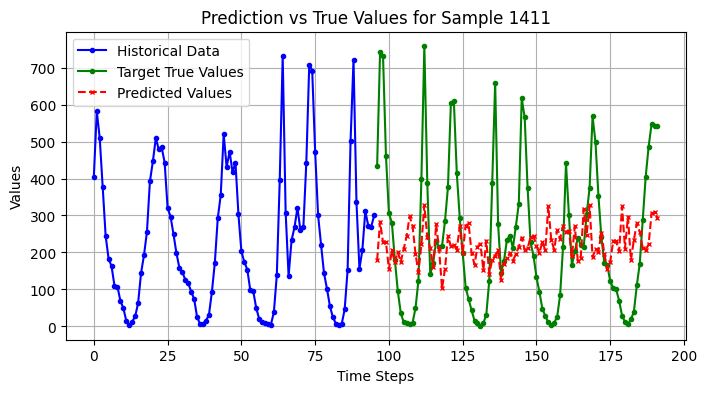

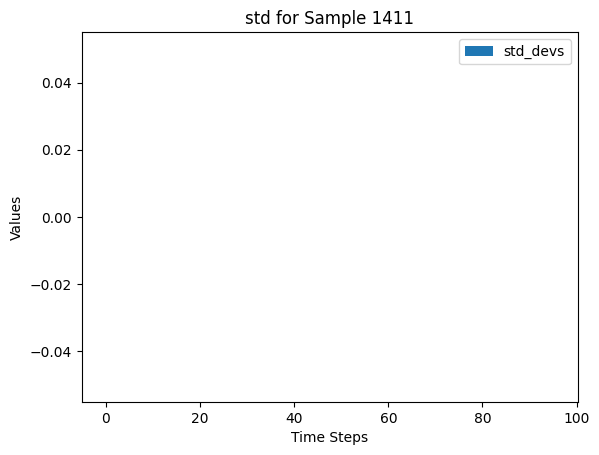

测试集上第1611个样本的MAE: 149.60684
测试集上第1611个样本的MSE: 31470.203


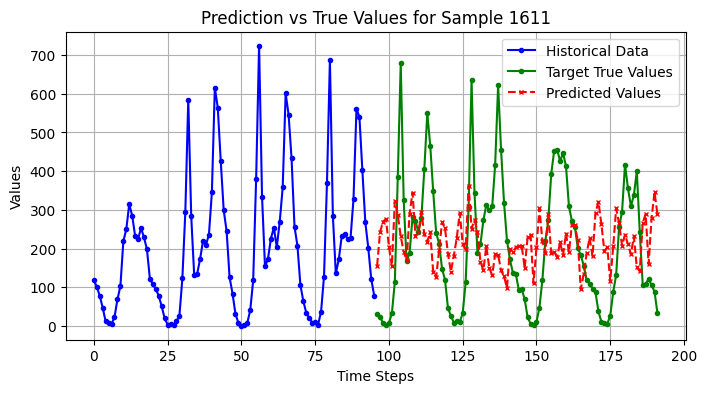

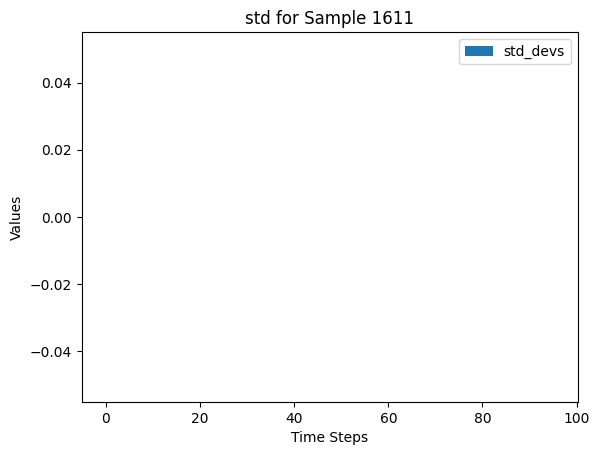

测试集上第1811个样本的MAE: 154.47462
测试集上第1811个样本的MSE: 28913.875


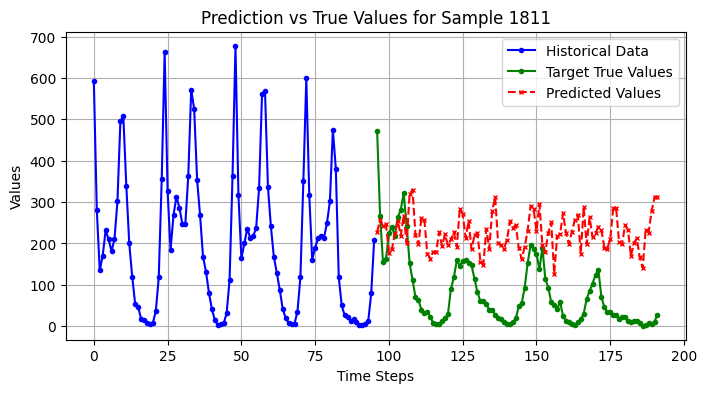

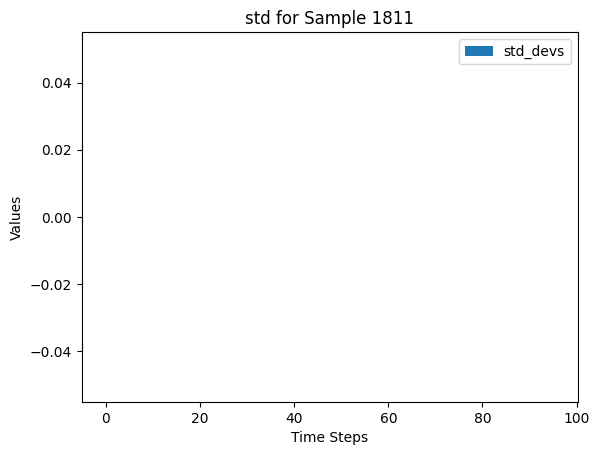

In [59]:
pred_array = np.load('pred_array_list_transformer.npy')
true_array = np.load('true_array_transformer.npy')
std_devs = np.std(pred_array, axis=0)
mean_values = np.mean(pred_array, axis=0)
# print(std_devs.shape,mean_values.shape)
print('5轮训练平均值:')
val_i = [10,210,410,610,810,1010,1210,1410,1610,1810]
for i in val_i:
    mae,mse = error(mean_values, true_array, i=i)
    print(f'测试集上第{i+1}个样本的MAE:', mae)
    print(f'测试集上第{i+1}个样本的MSE:', mse)
    draw_one_sample(mean_values, true_array, i = i)
    plt.bar(height = std_devs[i,:], label='std_devs',x=range(len(std_devs[i,:])))
    plt.legend()
    plt.title(f'std for Sample {i+1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()

